In [ ]:
import os

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import cv2
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import os

# 300 x 300
current_dir = '/content/drive/MyDrive/Colab Notebooks/dataset/Rock-Paper-Scissors/Rock-Paper-Scissors'
train_dir = os.path.join(current_dir, 'train')
test_dir = os.path.join(current_dir, 'test')
val_dir = os.path.join(current_dir, 'validation')

batch_size = 32
IMG_SHAPE = 224


In [ ]:
from google.colab.patches import cv2_imshow

def grayScaleImages(directory):
  imageArray = []
  labelArray = []
  for item in os.listdir(directory): #assuming gif
    current_dir=os.path.join(directory,item)
    for item1 in os.listdir(current_dir):
      image = cv2.imread(os.path.join(current_dir,item1))
      image = cv2.resize(image, (224,224))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      imageArray.append(image)
      labelArray.append(item1)
  return np.array(imageArray), np.array(labelArray)
      
train_images, train_labels = grayScaleImages(train_dir)
val_images, val_labels = grayScaleImages(val_dir)
test_images, test_labels =grayScaleImages(test_dir)

In [ ]:
from numpy.random.mtrand import shuffle
image_gen_train = ImageDataGenerator(rescale=1. / 255,
                                         rotation_range=45,
                                         zoom_range=.5,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         brightness_range=(.25, .5),
                                         width_shift_range=.15,
                                         height_shift_range=.15
                                         )

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size, directory=train_dir, shuffle=True,
                                                         target_size=(IMG_SHAPE, IMG_SHAPE), class_mode='sparse')

image_gen_val = ImageDataGenerator(rescale=1. / 255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size, directory=val_dir, shuffle=True,
                                                     target_size=(IMG_SHAPE, IMG_SHAPE), class_mode='sparse')

image_gen_test = ImageDataGenerator(rescale=1. / 255)
test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size, directory=test_dir, shuffle=True,
                                                       target_size=(IMG_SHAPE, IMG_SHAPE), class_mode='sparse')

Found 2520 images belonging to 3 classes.
Found 33 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


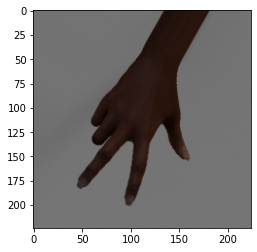

In [ ]:
plt.imshow(train_data_gen[1][0][3])

In [ ]:
steps_per_epoch = train_data_gen.n // batch_size
validation_steps = test_data_gen.n // batch_size
print(train_data_gen.n,test_data_gen.n)

2520 372


In [ ]:
module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                       input_shape=IMAGE_SIZE + (3,),
                                       output_shape=[FV_SIZE],
                                       trainable=False)
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(3, activation='softmax')
    ])

model.summary()

model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

EPOCHS = 1

hist = model.fit_generator(train_data_gen,
                  epochs=EPOCHS,
                  validation_data=test_data_gen)

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280
Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


79/79 [==============================] - 587s 7s/step - loss: 0.5165 - accuracy: 0.7964 - val_loss: 0.4199 - val_accuracy: 0.8737


In [ ]:
from google.colab.patches import cv2_imshow
import cv2
#0 paper, 1 rock, 2 is scissors

#augmented_images = [val_data_gen[0][0][i] for i in range(32)]
#predicted = model.predict_generator(val_data_gen)
#for i in range(32):
  #plt.imshow(augmented_images[i])
  #print(np.argmax(predicted[i]))

current_dir = '/content/drive/MyDrive/Colab Notebooks/dataset/Rock-Paper-Scissors/validation'
for item in os.listdir(current_dir):
  temp = os.path.join(current_dir, item)
  for item1 in os.listdir(temp):
    image = cv2.imread(os.path.join(temp, item1), cv2.IMREAD_UNCHANGED)
    cv2_imshow(image)
    predicted = model.predict_generator(image)
    print(np.argmax(predicted))




#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#gray = cv2.resize(image, (224,224))
#gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
#edged = cv2.Canny(gray, 30, 200)



#predicted = model.predict_generator(image)
#print(np.argmax(predicted))



In [ ]:
plt.imshow(augmented_images[2])

In [ ]:
model = tf.keras.models.Sequential()

# First convolution.
model.add(tf.keras.layers.Convolution2D(
    input_shape=(224,224,1),
    filters=64,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Second convolution.
model.add(tf.keras.layers.Convolution2D(
    filters=64,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Third convolution.
model.add(tf.keras.layers.Convolution2D(
    filters=128,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Fourth convolution.
model.add(tf.keras.layers.Convolution2D(
    filters=128,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Flatten the results to feed into dense layers.
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))

# 512 neuron dense layer.
model.add(tf.keras.layers.Dense(
    units=512,
    activation=tf.keras.activations.relu
))

# Output layer.
model.add(tf.keras.layers.Dense(
    units=3
))

#rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

training_history = model.fit_generator(
    train_data_gen,
    validation_data=test_data_gen,
    epochs=2
)